Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [53]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
Bio = pd.read_csv("Bioefficiency.csv")

In [133]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10 #0.107
tauc = 20
coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [134]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 26, 46)

In [135]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

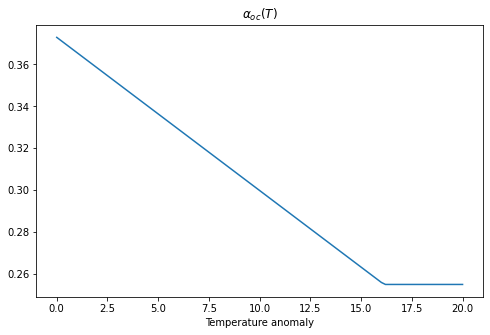

(0.255, 0.372950625)

In [136]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

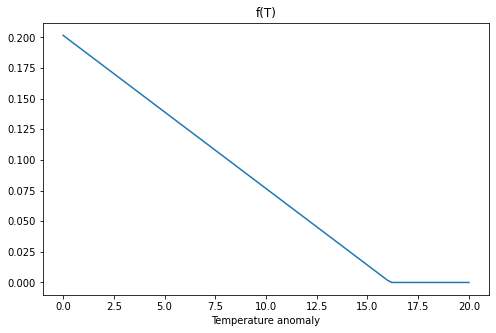

(0.0, 0.20162499999999994)

In [137]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

In [138]:
frac_sea_ice.mean()

0.08150123762376228

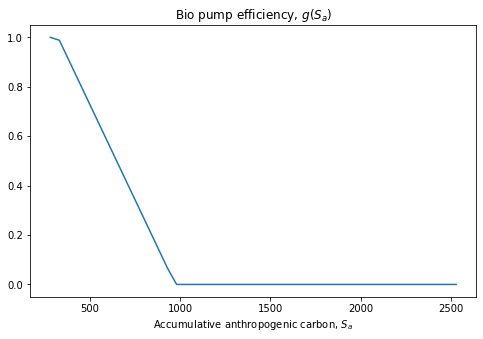

In [139]:
Fo = 272.3 # pre-industrial cumulated emission
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

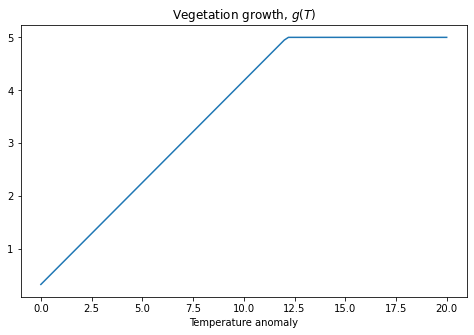

(0.33461538461538637, 5.0)

In [140]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

In [11]:
vege_growth.mean()

3.576047220106627

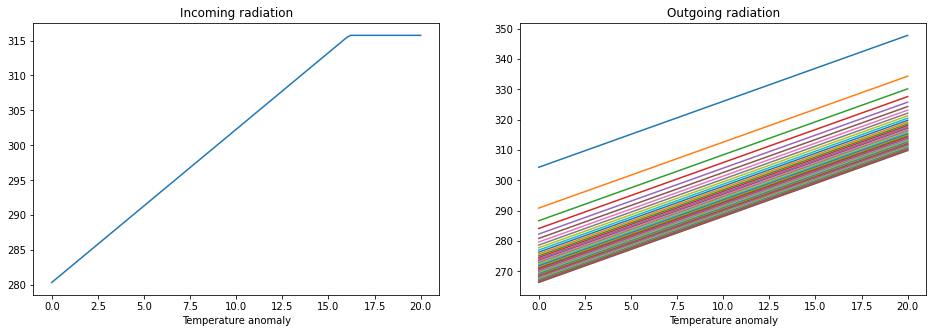

In [12]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

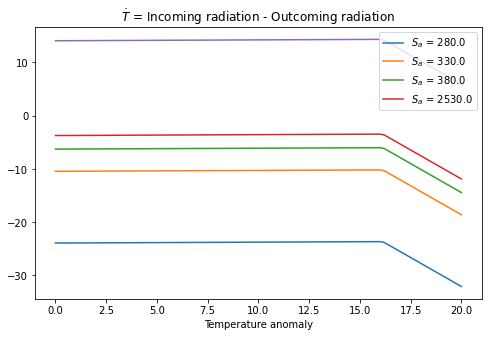

In [13]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [14]:
T_grid[5], F_grid[17], C_grid[1]

(1.0, 1130.0, 260)

In [15]:
(ri - ro)[6, 17], 10 * 1.86/1000

(7.607788131343909, 0.018600000000000002)

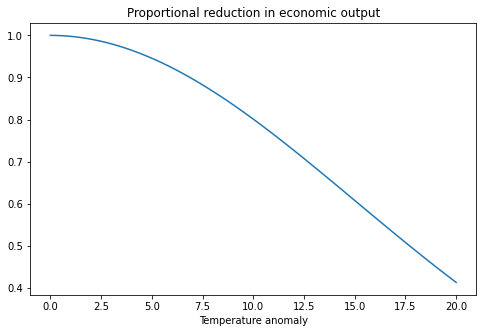

In [16]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [157]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 10. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500.
hC     = 5.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton, since 1800
F_min = 10. # 10. avaoid 
F_max = 800. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 10.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(51, 51, 80)

In [159]:
v0 =  - eta * T_mat - eta * F_mat
# v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 0.3
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 5000
fraction = 0.3


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0.0 * np.ones(T_mat.shape)
    C2 = 0.0 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.2597530558246083;	 PDE Error: 0.26034679342976613	
Iteration: 2;	 False Transient Error: 0.25915023852049285;	 PDE Error: 0.25975305792149667	
Iteration: 3;	 False Transient Error: 0.2585388691670569;	 PDE Error: 0.25915024104823736	
Iteration: 4;	 False Transient Error: 0.2579194534726052;	 PDE Error: 0.25853887217369065	
Iteration: 5;	 False Transient Error: 0.2572924744498195;	 PDE Error: 0.257919456938873	
Iteration: 6;	 False Transient Error: 0.25665839344411506;	 PDE Error: 0.257292478334541	
Iteration: 7;	 False Transient Error: 0.25601765109202057;	 PDE Error: 0.25665839770306825	
Iteration: 8;	 False Transient Error: 0.2553706682276887;	 PDE Error: 0.2560176556854808	
Iteration: 9;	 False Transient Error: 0.25471784674445297;	 PDE Error: 0.25537067312235373	
Iteration: 10;	 False Transient Error: 0.25405957041749383;	 PDE Error: 0.2547178519133871	
Iteration: 11;	 False Transient Error: 0.25339620569030313;	 PDE Error: 0.2540595758392406

Iteration: 90;	 False Transient Error: 0.2022642711841982;	 PDE Error: 0.2028886060612154	
Iteration: 91;	 False Transient Error: 0.2016405737726738;	 PDE Error: 0.2022642769661214	
Iteration: 92;	 False Transient Error: 0.20101758332547348;	 PDE Error: 0.20164057956760478	
Iteration: 93;	 False Transient Error: 0.20039537116919823;	 PDE Error: 0.20101758913303278	
Iteration: 94;	 False Transient Error: 0.19977400487315816;	 PDE Error: 0.2003953769894745	
Iteration: 95;	 False Transient Error: 0.1991535484232306;	 PDE Error: 0.19977401070520906	
Iteration: 96;	 False Transient Error: 0.19853406238908633;	 PDE Error: 0.1991535542668146	
Iteration: 97;	 False Transient Error: 0.1979156040827827;	 PDE Error: 0.19853406824439268	
Iteration: 98;	 False Transient Error: 0.19729822771000255;	 PDE Error: 0.1979156099491728	
Iteration: 99;	 False Transient Error: 0.19668198451448404;	 PDE Error: 0.1972982335868594	
Iteration: 100;	 False Transient Error: 0.19606692291671854;	 PDE Error: 0.19668

Iteration: 178;	 False Transient Error: 0.15322132686858225;	 PDE Error: 0.15370326794363157	
Iteration: 179;	 False Transient Error: 0.15274104997853755;	 PDE Error: 0.15322133323519066	
Iteration: 180;	 False Transient Error: 0.15226242495360864;	 PDE Error: 0.152741056349447	
Iteration: 181;	 False Transient Error: 0.15178544581606465;	 PDE Error: 0.15226243132862588	
Iteration: 182;	 False Transient Error: 0.15131010657087293;	 PDE Error: 0.15178545219532097	
Iteration: 183;	 False Transient Error: 0.15083640120761171;	 PDE Error: 0.15131011295410535	
Iteration: 184;	 False Transient Error: 0.15036432370344244;	 PDE Error: 0.150836407594958	
Iteration: 185;	 False Transient Error: 0.14989386802512902;	 PDE Error: 0.15036433009500313	
Iteration: 186;	 False Transient Error: 0.14942502813075484;	 PDE Error: 0.14989387442065774	
Iteration: 187;	 False Transient Error: 0.14895779797235775;	 PDE Error: 0.14942503453035103	
Iteration: 188;	 False Transient Error: 0.1484921714975111;	 PDE

Iteration: 266;	 False Transient Error: 0.11663567274130315;	 PDE Error: 0.11699380385209472	
Iteration: 267;	 False Transient Error: 0.11627872183832841;	 PDE Error: 0.1166356794128154	
Iteration: 268;	 False Transient Error: 0.11592293987481148;	 PDE Error: 0.11627872851274894	
Iteration: 269;	 False Transient Error: 0.11556832227306894;	 PDE Error: 0.11592294655197805	
Iteration: 270;	 False Transient Error: 0.11521486447797122;	 PDE Error: 0.1155683289531994	
Iteration: 271;	 False Transient Error: 0.1148625619562734;	 PDE Error: 0.11521487116086007	
Iteration: 272;	 False Transient Error: 0.11451141019717781;	 PDE Error: 0.11486256864203799	
Iteration: 273;	 False Transient Error: 0.11416140471194325;	 PDE Error: 0.11451141688580921	
Iteration: 274;	 False Transient Error: 0.11381254103384938;	 PDE Error: 0.11416141140330796	
Iteration: 275;	 False Transient Error: 0.11346481471843362;	 PDE Error: 0.11381254772806633	
Iteration: 276;	 False Transient Error: 0.11311822134334903;	 P

Iteration: 354;	 False Transient Error: 0.08924595478163155;	 PDE Error: 0.08951728206032601	
Iteration: 355;	 False Transient Error: 0.08897663710130863;	 PDE Error: 0.08924717897796068	
Iteration: 356;	 False Transient Error: 0.08870816260217278;	 PDE Error: 0.0889779213477189	
Iteration: 357;	 False Transient Error: 0.08844052833874017;	 PDE Error: 0.0887095062182417	
Iteration: 358;	 False Transient Error: 0.08817373137915752;	 PDE Error: 0.08844193065165057	
Iteration: 359;	 False Transient Error: 0.08790776880488238;	 PDE Error: 0.08817519172357596	
Iteration: 360;	 False Transient Error: 0.08764263771090224;	 PDE Error: 0.08790928652308282	
Iteration: 361;	 False Transient Error: 0.08737833520539695;	 PDE Error: 0.08764421215241085	
Iteration: 362;	 False Transient Error: 0.08711485840991648;	 PDE Error: 0.08737996572728543	
Iteration: 363;	 False Transient Error: 0.08685220445879457;	 PDE Error: 0.08711654437620296	
Iteration: 364;	 False Transient Error: 0.08659037049971138;	 

Iteration: 442;	 False Transient Error: 0.06847880020425912;	 PDE Error: 0.06868907994165685	
Iteration: 443;	 False Transient Error: 0.06827370424455323;	 PDE Error: 0.06848337655590045	
Iteration: 444;	 False Transient Error: 0.06806923591026268;	 PDE Error: 0.06827830259903277	
Iteration: 445;	 False Transient Error: 0.0678653931127767;	 PDE Error: 0.06807385601230126	
Iteration: 446;	 False Transient Error: 0.06766217374695553;	 PDE Error: 0.06787003470170978	
Iteration: 447;	 False Transient Error: 0.06745957571091607;	 PDE Error: 0.06766683656153007	
Iteration: 448;	 False Transient Error: 0.06725759691924202;	 PDE Error: 0.06746425949243215	
Iteration: 449;	 False Transient Error: 0.06705623531089464;	 PDE Error: 0.06726230141425565	
Iteration: 450;	 False Transient Error: 0.06685548885145091;	 PDE Error: 0.0670609602722816	
Iteration: 451;	 False Transient Error: 0.06665535553140423;	 PDE Error: 0.06686023403856457	
Iteration: 452;	 False Transient Error: 0.06645583336264416;	 

Iteration: 530;	 False Transient Error: 0.05262519321890776;	 PDE Error: 0.05278836660359998	
Iteration: 531;	 False Transient Error: 0.05246828468204494;	 PDE Error: 0.05263099033693024	
Iteration: 532;	 False Transient Error: 0.05231185045052082;	 PDE Error: 0.052474089763038065	
Iteration: 533;	 False Transient Error: 0.05215588905009246;	 PDE Error: 0.05231766340363831	
Iteration: 534;	 False Transient Error: 0.052000399011363406;	 PDE Error: 0.052161709785399725	
Iteration: 535;	 False Transient Error: 0.051845378869949485;	 PDE Error: 0.052006227439977674	
Iteration: 536;	 False Transient Error: 0.051690827166239;	 PDE Error: 0.05185121490384619	
Iteration: 537;	 False Transient Error: 0.05153674244564736;	 PDE Error: 0.05169667071854246	
Iteration: 538;	 False Transient Error: 0.051383123258291384;	 PDE Error: 0.051542593430289066	
Iteration: 539;	 False Transient Error: 0.051229968159178796;	 PDE Error: 0.05138898159017607	
Iteration: 540;	 False Transient Error: 0.051077275708

Iteration: 617;	 False Transient Error: 0.0406025866649055;	 PDE Error: 0.04072985864977507	
Iteration: 618;	 False Transient Error: 0.04048191201818578;	 PDE Error: 0.04060882311043981	
Iteration: 619;	 False Transient Error: 0.04036160009422159;	 PDE Error: 0.040488151369775016	
Iteration: 620;	 False Transient Error: 0.04024164978672455;	 PDE Error: 0.04036784231839916	
Iteration: 621;	 False Transient Error: 0.040122059992813895;	 PDE Error: 0.04024789485021612	
Iteration: 622;	 False Transient Error: 0.04000282961315271;	 PDE Error: 0.04012830786270344	
Iteration: 623;	 False Transient Error: 0.03988395755198345;	 PDE Error: 0.040009080257004045	
Iteration: 624;	 False Transient Error: 0.03976544271706869;	 PDE Error: 0.03989021093769663	
Iteration: 625;	 False Transient Error: 0.03964728401958162;	 PDE Error: 0.0397716988128647	
Iteration: 626;	 False Transient Error: 0.03952948037425408;	 PDE Error: 0.03965354279410381	
Iteration: 627;	 False Transient Error: 0.03941203069926995

Iteration: 704;	 False Transient Error: 0.031351009705954766;	 PDE Error: 0.03145059176980326	
Iteration: 705;	 False Transient Error: 0.03125810195368839;	 PDE Error: 0.03135740575790995	
Iteration: 706;	 False Transient Error: 0.031165472676200068;	 PDE Error: 0.031264499051879134	
Iteration: 707;	 False Transient Error: 0.031073121032479577;	 PDE Error: 0.031171870808209788	
Iteration: 708;	 False Transient Error: 0.03098104618412793;	 PDE Error: 0.03107952018606959	
Iteration: 709;	 False Transient Error: 0.030889247295392924;	 PDE Error: 0.030987446347235298	
Iteration: 710;	 False Transient Error: 0.03079772353302701;	 PDE Error: 0.03089564845600569	
Iteration: 711;	 False Transient Error: 0.030706474066398336;	 PDE Error: 0.03080412567930461	
Iteration: 712;	 False Transient Error: 0.030615498067465552;	 PDE Error: 0.03071287718667741	
Iteration: 713;	 False Transient Error: 0.030524794710699393;	 PDE Error: 0.030621902150165442	
Iteration: 714;	 False Transient Error: 0.0304343

Iteration: 791;	 False Transient Error: 0.024226221553994936;	 PDE Error: 0.024304393253259726	
Iteration: 792;	 False Transient Error: 0.02415466179542136;	 PDE Error: 0.024232609883810395	
Iteration: 793;	 False Transient Error: 0.02408331684010445;	 PDE Error: 0.02416104134863302	
Iteration: 794;	 False Transient Error: 0.02401219024222486;	 PDE Error: 0.02408968700194719	
Iteration: 795;	 False Transient Error: 0.023941304357621245;	 PDE Error: 0.024018546199975503	
Iteration: 796;	 False Transient Error: 0.02387063037511794;	 PDE Error: 0.02394761830090192	
Iteration: 797;	 False Transient Error: 0.02380016766121873;	 PDE Error: 0.023876902664787397	
Iteration: 798;	 False Transient Error: 0.023729915584332538;	 PDE Error: 0.023806398653722746	
Iteration: 799;	 False Transient Error: 0.023659873514776386;	 PDE Error: 0.023736105631726692	
Iteration: 800;	 False Transient Error: 0.023590040824692515;	 PDE Error: 0.02366602296470019	
Iteration: 801;	 False Transient Error: 0.0235204

Iteration: 878;	 False Transient Error: 0.018740100007811716;	 PDE Error: 0.018800166153293236	
Iteration: 879;	 False Transient Error: 0.018684981170894826;	 PDE Error: 0.018744881884665065	
Iteration: 880;	 False Transient Error: 0.018630027068739324;	 PDE Error: 0.01868976284504184	
Iteration: 881;	 False Transient Error: 0.01857523720893317;	 PDE Error: 0.018634808540539356	
Iteration: 882;	 False Transient Error: 0.01852061110053797;	 PDE Error: 0.018580018478741005	
Iteration: 883;	 False Transient Error: 0.01846614825407415;	 PDE Error: 0.018525392168693647	
Iteration: 884;	 False Transient Error: 0.01841184818151209;	 PDE Error: 0.01847092912090397	
Iteration: 885;	 False Transient Error: 0.018357710396281757;	 PDE Error: 0.018416628847338842	
Iteration: 886;	 False Transient Error: 0.01830373441326009;	 PDE Error: 0.018362490861416645	
Iteration: 887;	 False Transient Error: 0.01824991974876881;	 PDE Error: 0.018308514678002243	
Iteration: 888;	 False Transient Error: 0.018196

Iteration: 964;	 False Transient Error: 0.014554561262689614;	 PDE Error: 0.014602064230851006	
Iteration: 965;	 False Transient Error: 0.014511951149043986;	 PDE Error: 0.014559326207007305	
Iteration: 966;	 False Transient Error: 0.014469468364414578;	 PDE Error: 0.014516715894038265	
Iteration: 967;	 False Transient Error: 0.014427112527866845;	 PDE Error: 0.014474232909871262	
Iteration: 968;	 False Transient Error: 0.014384883259620137;	 PDE Error: 0.014431876873567694	
Iteration: 969;	 False Transient Error: 0.014342780180992184;	 PDE Error: 0.01438964740532413	
Iteration: 970;	 False Transient Error: 0.014300802914460528;	 PDE Error: 0.014347544126475386	
Iteration: 971;	 False Transient Error: 0.014258951083605531;	 PDE Error: 0.014305566659477041	
Iteration: 972;	 False Transient Error: 0.014217224313147389;	 PDE Error: 0.014263714627924019	
Iteration: 973;	 False Transient Error: 0.014175622228929097;	 PDE Error: 0.014221987656523856	
Iteration: 974;	 False Transient Error: 0

Iteration: 1050;	 False Transient Error: 0.011318794265123463;	 PDE Error: 0.011356582467446811	
Iteration: 1051;	 False Transient Error: 0.011285851586052924;	 PDE Error: 0.011323540865053276	
Iteration: 1052;	 False Transient Error: 0.011253007303366019;	 PDE Error: 0.011290597954007145	
Iteration: 1053;	 False Transient Error: 0.011220261122453964;	 PDE Error: 0.011257753438817993	
Iteration: 1054;	 False Transient Error: 0.011187612749601339;	 PDE Error: 0.011225007024883651	
Iteration: 1055;	 False Transient Error: 0.011155061891960916;	 PDE Error: 0.011192358418481006	
Iteration: 1056;	 False Transient Error: 0.011122608257564023;	 PDE Error: 0.011159807326760288	
Iteration: 1057;	 False Transient Error: 0.011090251555307962;	 PDE Error: 0.011127353457750785	
Iteration: 1058;	 False Transient Error: 0.011057991494958971;	 PDE Error: 0.011094996520348099	
Iteration: 1059;	 False Transient Error: 0.011025827787162584;	 PDE Error: 0.011062736224322354	
Iteration: 1060;	 False Transi

Iteration: 1135;	 False Transient Error: 0.008842541534655654;	 PDE Error: 0.008872891992289758	
Iteration: 1136;	 False Transient Error: 0.008816992605040763;	 PDE Error: 0.008847266298490973	
Iteration: 1137;	 False Transient Error: 0.008791519925788934;	 PDE Error: 0.008821717083510082	
Iteration: 1138;	 False Transient Error: 0.008766123268397763;	 PDE Error: 0.008796244118162884	
Iteration: 1139;	 False Transient Error: 0.008740802405058739;	 PDE Error: 0.008770847173951235	
Iteration: 1140;	 False Transient Error: 0.00871555710863392;	 PDE Error: 0.008745526023057072	
Iteration: 1141;	 False Transient Error: 0.008690387152667789;	 PDE Error: 0.00872028043834264	
Iteration: 1142;	 False Transient Error: 0.008665292311374658;	 PDE Error: 0.00869511019334702	
Iteration: 1143;	 False Transient Error: 0.008640272359646078;	 PDE Error: 0.008670015062286028	
Iteration: 1144;	 False Transient Error: 0.008615327073050091;	 PDE Error: 0.008644994820049868	
Iteration: 1145;	 False Transient

Iteration: 1220;	 False Transient Error: 0.00692184382715566;	 PDE Error: 0.006946421079720754	
Iteration: 1221;	 False Transient Error: 0.006902023847577729;	 PDE Error: 0.006926541495007184	
Iteration: 1222;	 False Transient Error: 0.00688226294029611;	 PDE Error: 0.006906721159461288	
Iteration: 1223;	 False Transient Error: 0.006862560928045566;	 PDE Error: 0.006886959895280381	
Iteration: 1224;	 False Transient Error: 0.006842917634088952;	 PDE Error: 0.006867257525198556	
Iteration: 1225;	 False Transient Error: 0.006823332882222033;	 PDE Error: 0.006847613872478351	
Iteration: 1226;	 False Transient Error: 0.006803806496766078;	 PDE Error: 0.006828028760914648	
Iteration: 1227;	 False Transient Error: 0.006784338302570451;	 PDE Error: 0.006808502014831255	
Iteration: 1228;	 False Transient Error: 0.006764928125019276;	 PDE Error: 0.0067890334590795685	
Iteration: 1229;	 False Transient Error: 0.006745575790003308;	 PDE Error: 0.006769622919035081	
Iteration: 1230;	 False Transie

Iteration: 1305;	 False Transient Error: 0.0054315480446061794;	 PDE Error: 0.005451640691555903	
Iteration: 1306;	 False Transient Error: 0.005416165618318999;	 PDE Error: 0.005436211938767968	
Iteration: 1307;	 False Transient Error: 0.0054008289388326105;	 PDE Error: 0.00542082906958538	
Iteration: 1308;	 False Transient Error: 0.00538553786863516;	 PDE Error: 0.005405491946081209	
Iteration: 1309;	 False Transient Error: 0.005370292270622246;	 PDE Error: 0.005390200430736831	
Iteration: 1310;	 False Transient Error: 0.0053550920080958075;	 PDE Error: 0.005374954386447254	
Iteration: 1311;	 False Transient Error: 0.005339936944770049;	 PDE Error: 0.005359753676513451	
Iteration: 1312;	 False Transient Error: 0.005324826944764402;	 PDE Error: 0.005344598164646872	
Iteration: 1313;	 False Transient Error: 0.005309761872603162;	 PDE Error: 0.005329487714964187	
Iteration: 1314;	 False Transient Error: 0.005294741593213267;	 PDE Error: 0.005314422191987624	
Iteration: 1315;	 False Trans

Iteration: 1390;	 False Transient Error: 0.004274567539157929;	 PDE Error: 0.004291172339450479	
Iteration: 1391;	 False Transient Error: 0.004262620809900956;	 PDE Error: 0.004279189549845968	
Iteration: 1392;	 False Transient Error: 0.004250709488589077;	 PDE Error: 0.004267242273894417	
Iteration: 1393;	 False Transient Error: 0.004238833468534672;	 PDE Error: 0.004255330404584851	
Iteration: 1394;	 False Transient Error: 0.004226992643369491;	 PDE Error: 0.0042434538352294	
Iteration: 1395;	 False Transient Error: 0.004215186907048733;	 PDE Error: 0.004231612459460454	
Iteration: 1396;	 False Transient Error: 0.004203416153843269;	 PDE Error: 0.0042198061712302596	
Iteration: 1397;	 False Transient Error: 0.004191680278338532;	 PDE Error: 0.004208034864812262	
Iteration: 1398;	 False Transient Error: 0.004179979175450063;	 PDE Error: 0.004196298434796876	
Iteration: 1399;	 False Transient Error: 0.004168312740395012;	 PDE Error: 0.004184596776087057	
Iteration: 1400;	 False Transie

Iteration: 1474;	 False Transient Error: 0.0033848924518862606;	 PDE Error: 0.003398807816327825	
Iteration: 1475;	 False Transient Error: 0.003375576538618419;	 PDE Error: 0.003389463687804668	
Iteration: 1476;	 False Transient Error: 0.0033662880913308086;	 PDE Error: 0.003380147107077182	
Iteration: 1477;	 False Transient Error: 0.0033570270269026965;	 PDE Error: 0.0033708579907711345	
Iteration: 1478;	 False Transient Error: 0.0033477932624492723;	 PDE Error: 0.00336159625575751	
Iteration: 1479;	 False Transient Error: 0.003338586715339783;	 PDE Error: 0.003352361819155007	
Iteration: 1480;	 False Transient Error: 0.0033294073031792104;	 PDE Error: 0.0033431545983255485	
Iteration: 1481;	 False Transient Error: 0.0033202549438254847;	 PDE Error: 0.0033339745108770524	
Iteration: 1482;	 False Transient Error: 0.003311129555370977;	 PDE Error: 0.003324821474659426	
Iteration: 1483;	 False Transient Error: 0.0033020310561523067;	 PDE Error: 0.0033156954077647803	
Iteration: 1484;	 Fa

Iteration: 1558;	 False Transient Error: 0.0026906362143330753;	 PDE Error: 0.0027024443149727745	
Iteration: 1559;	 False Transient Error: 0.0026833598476318685;	 PDE Error: 0.0026951458024707907	
Iteration: 1560;	 False Transient Error: 0.002676104759919233;	 PDE Error: 0.002687868632165795	
Iteration: 1561;	 False Transient Error: 0.0026688708865211614;	 PDE Error: 0.0026806127391869917	
Iteration: 1562;	 False Transient Error: 0.0026616581629477594;	 PDE Error: 0.002673378058853638	
Iteration: 1563;	 False Transient Error: 0.002654466524904901;	 PDE Error: 0.002666164526675593	
Iteration: 1564;	 False Transient Error: 0.002647295908281648;	 PDE Error: 0.0026589720783523215	
Iteration: 1565;	 False Transient Error: 0.0026401462491570937;	 PDE Error: 0.0026518006497705275	
Iteration: 1566;	 False Transient Error: 0.002633017483799257;	 PDE Error: 0.002644650177006324	
Iteration: 1567;	 False Transient Error: 0.0026259095486597106;	 PDE Error: 0.0026375205963210992	
Iteration: 1568;	 

Iteration: 1642;	 False Transient Error: 0.0021477887566388283;	 PDE Error: 0.0021579395570154756	
Iteration: 1643;	 False Transient Error: 0.0021420915354667764;	 PDE Error: 0.002152224875877921	
Iteration: 1644;	 False Transient Error: 0.002136410778148523;	 PDE Error: 0.0021465267073491135	
Iteration: 1645;	 False Transient Error: 0.0021307464344131706;	 PDE Error: 0.002140845001004627	
Iteration: 1646;	 False Transient Error: 0.0021250984541352587;	 PDE Error: 0.0021351797065702026	
Iteration: 1647;	 False Transient Error: 0.00211946678734624;	 PDE Error: 0.0021295307739234324	
Iteration: 1648;	 False Transient Error: 0.002113851384221155;	 PDE Error: 0.0021238981530874185	
Iteration: 1649;	 False Transient Error: 0.0021082521950830753;	 PDE Error: 0.0021182817942347085	
Iteration: 1650;	 False Transient Error: 0.0021026691704055063;	 PDE Error: 0.0021126816476876443	
Iteration: 1651;	 False Transient Error: 0.0020971022608051726;	 PDE Error: 0.002107097663914039	
Iteration: 1652;	

Iteration: 1726;	 False Transient Error: 0.0017221014587386527;	 PDE Error: 0.0017309419503343715	
Iteration: 1727;	 False Transient Error: 0.0017176254482748992;	 PDE Error: 0.0017264520880516155	
Iteration: 1728;	 False Transient Error: 0.0017131621631314802;	 PDE Error: 0.001721974988611469	
Iteration: 1729;	 False Transient Error: 0.0017087115642355766;	 PDE Error: 0.0017175106128216942	
Iteration: 1730;	 False Transient Error: 0.0017042736126358464;	 PDE Error: 0.0017130589216106237	
Iteration: 1731;	 False Transient Error: 0.0016998482695001114;	 PDE Error: 0.0017086198760277976	
Iteration: 1732;	 False Transient Error: 0.00169543549611804;	 PDE Error: 0.0017041934372437886	
Iteration: 1733;	 False Transient Error: 0.00169103525389791;	 PDE Error: 0.00169977956654938	
Iteration: 1734;	 False Transient Error: 0.0016866475043690137;	 PDE Error: 0.0016953782253562057	
Iteration: 1735;	 False Transient Error: 0.0016822722091792512;	 PDE Error: 0.001690989375195333	
Iteration: 1736;	 

Iteration: 1810;	 False Transient Error: 0.0013869718928002004;	 PDE Error: 0.0013947691612897018	
Iteration: 1811;	 False Transient Error: 0.0013834391995506956;	 PDE Error: 0.0013912253940769708	
Iteration: 1812;	 False Transient Error: 0.0013799163293817807;	 PDE Error: 0.0013876914788270008	
Iteration: 1813;	 False Transient Error: 0.001376403252074295;	 PDE Error: 0.0013841673852305703	
Iteration: 1814;	 False Transient Error: 0.001372899937500116;	 PDE Error: 0.0013806530830696821	
Iteration: 1815;	 False Transient Error: 0.0013694063556174418;	 PDE Error: 0.001377148542214608	
Iteration: 1816;	 False Transient Error: 0.0013659224764774511;	 PDE Error: 0.0013736537326262581	
Iteration: 1817;	 False Transient Error: 0.0013624482702152367;	 PDE Error: 0.00137016862435366	
Iteration: 1818;	 False Transient Error: 0.0013589837070591508;	 PDE Error: 0.0013666931875348115	
Iteration: 1819;	 False Transient Error: 0.0013555287573205343;	 PDE Error: 0.0013632273923954246	
Iteration: 1820

Iteration: 1894;	 False Transient Error: 0.001121758786563528;	 PDE Error: 0.0011287185407380218	
Iteration: 1895;	 False Transient Error: 0.0011189542254252025;	 PDE Error: 0.0011259050449582972	
Iteration: 1896;	 False Transient Error: 0.0011161572509256943;	 PDE Error: 0.0011230991580488598	
Iteration: 1897;	 False Transient Error: 0.001113367839938965;	 PDE Error: 0.001120300856814062	
Iteration: 1898;	 False Transient Error: 0.0011105859694189129;	 PDE Error: 0.0011175101181389864	
Iteration: 1899;	 False Transient Error: 0.0011078116163981688;	 PDE Error: 0.0011147269189863995	
Iteration: 1900;	 False Transient Error: 0.0011050447579838418;	 PDE Error: 0.001111951236395864	
Iteration: 1901;	 False Transient Error: 0.0011022853713611263;	 PDE Error: 0.001109183047484784	
Iteration: 1902;	 False Transient Error: 0.0010995334337894163;	 PDE Error: 0.0011064223294442	
Iteration: 1903;	 False Transient Error: 0.001096788922599068;	 PDE Error: 0.0011036690595387115	
Iteration: 1904;	 F

Iteration: 1978;	 False Transient Error: 0.0009105521311251568;	 PDE Error: 0.0009168328451691682	
Iteration: 1979;	 False Transient Error: 0.0009083107243302673;	 PDE Error: 0.0009145841557671594	
Iteration: 1980;	 False Transient Error: 0.0009060751944626559;	 PDE Error: 0.000912341360567591	
Iteration: 1981;	 False Transient Error: 0.0009038455238448891;	 PDE Error: 0.0009101044418388736	
Iteration: 1982;	 False Transient Error: 0.000901621694865129;	 PDE Error: 0.0009078733819151799	
Iteration: 1983;	 False Transient Error: 0.0008994036899776885;	 PDE Error: 0.0009056481631966734	
Iteration: 1984;	 False Transient Error: 0.0008971914916981276;	 PDE Error: 0.0009034287681467317	
Iteration: 1985;	 False Transient Error: 0.0008949850826056593;	 PDE Error: 0.0009012151792922825	
Iteration: 1986;	 False Transient Error: 0.0008927844453388012;	 PDE Error: 0.0008990073792207564	
Iteration: 1987;	 False Transient Error: 0.0008905895625972253;	 PDE Error: 0.0008968053505803629	
Iteration: 1

Iteration: 2061;	 False Transient Error: 0.0007429920035102733;	 PDE Error: 0.000748722643451304	
Iteration: 2062;	 False Transient Error: 0.0007411832415454382;	 PDE Error: 0.000746907892691435	
Iteration: 2063;	 False Transient Error: 0.0007393790935192787;	 PDE Error: 0.0007450977448449528	
Iteration: 2064;	 False Transient Error: 0.0007375795239168241;	 PDE Error: 0.0007432921923627569	
Iteration: 2065;	 False Transient Error: 0.0007357845210542262;	 PDE Error: 0.0007414912212185608	
Iteration: 2066;	 False Transient Error: 0.0007339940722586129;	 PDE Error: 0.0007396948178773673	
Iteration: 2067;	 False Transient Error: 0.0007322081645850613;	 PDE Error: 0.0007379029690985213	
Iteration: 2068;	 False Transient Error: 0.0007304267849929843;	 PDE Error: 0.0007361156617563479	
Iteration: 2069;	 False Transient Error: 0.0007286499203879953;	 PDE Error: 0.0007343328827364381	
Iteration: 2070;	 False Transient Error: 0.0007268775576364332;	 PDE Error: 0.0007325546188949328	
Iteration: 2

Iteration: 2144;	 False Transient Error: 0.000607351345858533;	 PDE Error: 0.0006126261617674302	
Iteration: 2145;	 False Transient Error: 0.000605882333603545;	 PDE Error: 0.0006111521489307315	
Iteration: 2146;	 False Transient Error: 0.0006044169462598541;	 PDE Error: 0.0006096817718610535	
Iteration: 2147;	 False Transient Error: 0.0006029551737153176;	 PDE Error: 0.0006082150204167968	
Iteration: 2148;	 False Transient Error: 0.0006014970059003977;	 PDE Error: 0.0006067518844974883	
Iteration: 2149;	 False Transient Error: 0.0006000424327833043;	 PDE Error: 0.0006052923540416995	
Iteration: 2150;	 False Transient Error: 0.0005985914443713825;	 PDE Error: 0.0006038364190270925	
Iteration: 2151;	 False Transient Error: 0.0005971440307086611;	 PDE Error: 0.0006023840694694677	
Iteration: 2152;	 False Transient Error: 0.0005957001818771476;	 PDE Error: 0.0006009352954215553	
Iteration: 2153;	 False Transient Error: 0.0005942598879919252;	 PDE Error: 0.0005994900869713467	
Iteration: 2

Iteration: 2227;	 False Transient Error: 0.0004968895049483706;	 PDE Error: 0.0005017838376313747	
Iteration: 2228;	 False Transient Error: 0.0004956899008377869;	 PDE Error: 0.0005005800477956109	
Iteration: 2229;	 False Transient Error: 0.0004944931896607811;	 PDE Error: 0.0004993791597413321	
Iteration: 2230;	 False Transient Error: 0.0004932993638090873;	 PDE Error: 0.0004981811658379127	
Iteration: 2231;	 False Transient Error: 0.0004921084156964128;	 PDE Error: 0.0004969860584791443	
Iteration: 2232;	 False Transient Error: 0.0004909203377645907;	 PDE Error: 0.0004957938300852176	
Iteration: 2233;	 False Transient Error: 0.0004897351224799248;	 PDE Error: 0.0004946044731013576	
Iteration: 2234;	 False Transient Error: 0.0004885527623356423;	 PDE Error: 0.0004934179799985896	
Iteration: 2235;	 False Transient Error: 0.00048737324984995023;	 PDE Error: 0.0004922343432742095	
Iteration: 2236;	 False Transient Error: 0.00048619657756857987;	 PDE Error: 0.0004910535554521872	
Iteratio

Iteration: 2310;	 False Transient Error: 0.00040651205706861615;	 PDE Error: 0.0004110872845637984	
Iteration: 2311;	 False Transient Error: 0.0004055288210662774;	 PDE Error: 0.0004101005335065748	
Iteration: 2312;	 False Transient Error: 0.00040454792259577343;	 PDE Error: 0.0004091161273857306	
Iteration: 2313;	 False Transient Error: 0.00040356935575682395;	 PDE Error: 0.0004081340602845383	
Iteration: 2314;	 False Transient Error: 0.00040259311466876263;	 PDE Error: 0.0004071543263068666	
Iteration: 2315;	 False Transient Error: 0.00040161919347386776;	 PDE Error: 0.0004061769195777446	
Iteration: 2316;	 False Transient Error: 0.00040064758633528064;	 PDE Error: 0.00040520183424357244	
Iteration: 2317;	 False Transient Error: 0.00039967828743853184;	 PDE Error: 0.0004042290644727934	
Iteration: 2318;	 False Transient Error: 0.00039871129099186553;	 PDE Error: 0.0004032586044565968	
Iteration: 2319;	 False Transient Error: 0.00039774659122563766;	 PDE Error: 0.0004022904484082126	


Iteration: 2393;	 False Transient Error: 0.0003323495979189647;	 PDE Error: 0.0003366569134378427	
Iteration: 2394;	 False Transient Error: 0.00033154192632343465;	 PDE Error: 0.00033584629232364456	
Iteration: 2395;	 False Transient Error: 0.00033073616050126786;	 PDE Error: 0.00033503758323298523	
Iteration: 2396;	 False Transient Error: 0.00032993229589499873;	 PDE Error: 0.00033423078159593926	
Iteration: 2397;	 False Transient Error: 0.00032913032796034564;	 PDE Error: 0.0003334258828556545	
Iteration: 2398;	 False Transient Error: 0.00032833025216607214;	 PDE Error: 0.0003326228824689667	
Iteration: 2399;	 False Transient Error: 0.0003275320639953283;	 PDE Error: 0.0003318217759062492	
Iteration: 2400;	 False Transient Error: 0.00032673575894296797;	 PDE Error: 0.0003310225586502634	
Iteration: 2401;	 False Transient Error: 0.0003259413325171212;	 PDE Error: 0.00033022522619698586	
Iteration: 2402;	 False Transient Error: 0.00032514878023891713;	 PDE Error: 0.00032942977405574073

Iteration: 2475;	 False Transient Error: 0.0002720679831786736;	 PDE Error: 0.0002761531505292315	
Iteration: 2476;	 False Transient Error: 0.00027140254397595154;	 PDE Error: 0.00027548523555190297	
Iteration: 2477;	 False Transient Error: 0.0002707386765546614;	 PDE Error: 0.0002748188976945101	
Iteration: 2478;	 False Transient Error: 0.0002700763772607353;	 PDE Error: 0.0002741541332938464	
Iteration: 2479;	 False Transient Error: 0.00026941564244836275;	 PDE Error: 0.0002734909386950276	
Iteration: 2480;	 False Transient Error: 0.0002687564684798518;	 PDE Error: 0.0002728293102507976	
Iteration: 2481;	 False Transient Error: 0.00026809885172444925;	 PDE Error: 0.00027216924432155024	
Iteration: 2482;	 False Transient Error: 0.0002674427885610009;	 PDE Error: 0.0002715107372765503	
Iteration: 2483;	 False Transient Error: 0.00026678827537563826;	 PDE Error: 0.00027085378549265545	
Iteration: 2484;	 False Transient Error: 0.00026613530856379097;	 PDE Error: 0.0002701983853556213	
It

Iteration: 2557;	 False Transient Error: 0.00022241307711196034;	 PDE Error: 0.00022631213203360573	
Iteration: 2558;	 False Transient Error: 0.0002218651341294222;	 PDE Error: 0.00022576211998540595	
Iteration: 2559;	 False Transient Error: 0.00022131849085248179;	 PDE Error: 0.00022521341222886908	
Iteration: 2560;	 False Transient Error: 0.00022077314429299705;	 PDE Error: 0.00022466600576786773	
Iteration: 2561;	 False Transient Error: 0.00022022909147043543;	 PDE Error: 0.00022411989761350214	
Iteration: 2562;	 False Transient Error: 0.00021968632941057886;	 PDE Error: 0.0002235750847833912	
Iteration: 2563;	 False Transient Error: 0.00021914485514640258;	 PDE Error: 0.00022303156430192512	
Iteration: 2564;	 False Transient Error: 0.0002186046657174275;	 PDE Error: 0.00022248933320051197	
Iteration: 2565;	 False Transient Error: 0.0002180657581708073;	 PDE Error: 0.0002219483885174565	
Iteration: 2566;	 False Transient Error: 0.00021752812956021828;	 PDE Error: 0.00022140872729814

Iteration: 2639;	 False Transient Error: 0.00018154560446935938;	 PDE Error: 0.00018528948224172815	
Iteration: 2640;	 False Transient Error: 0.000181094916840846;	 PDE Error: 0.00018483707385607114	
Iteration: 2641;	 False Transient Error: 0.0001806453056232375;	 PDE Error: 0.00018438574602143513	
Iteration: 2642;	 False Transient Error: 0.00018019676863947898;	 PDE Error: 0.0001839354963614106	
Iteration: 2643;	 False Transient Error: 0.00017974930387349802;	 PDE Error: 0.00018348632250763817	
Iteration: 2644;	 False Transient Error: 0.00017930290827245882;	 PDE Error: 0.00018303822196921976	
Iteration: 2645;	 False Transient Error: 0.00017885757963682453;	 PDE Error: 0.00018259119234776468	
Iteration: 2646;	 False Transient Error: 0.00017841331592838758;	 PDE Error: 0.00018214523123838867	
Iteration: 2647;	 False Transient Error: 0.0001779701140232117;	 PDE Error: 0.00018170033609911314	
Iteration: 2648;	 False Transient Error: 0.00017752797170108212;	 PDE Error: 0.00018125650449654

Iteration: 2721;	 False Transient Error: 0.00014795569025211527;	 PDE Error: 0.0001515708579436571	
Iteration: 2722;	 False Transient Error: 0.00014758557125305513;	 PDE Error: 0.00015119931570966205	
Iteration: 2723;	 False Transient Error: 0.00014721634441843917;	 PDE Error: 0.00015082866894513338	
Iteration: 2724;	 False Transient Error: 0.00014684800809035745;	 PDE Error: 0.00015045891566129593	
Iteration: 2725;	 False Transient Error: 0.00014648055935243914;	 PDE Error: 0.0001500900536538603	
Iteration: 2726;	 False Transient Error: 0.00014611399666670152;	 PDE Error: 0.0001497220809808012	
Iteration: 2727;	 False Transient Error: 0.00014574831838321442;	 PDE Error: 0.0001493549956647209	
Iteration: 2728;	 False Transient Error: 0.0001453835215927078;	 PDE Error: 0.00014898879551148477	
Iteration: 2729;	 False Transient Error: 0.00014501960477651216;	 PDE Error: 0.000148623478592724	
Iteration: 2730;	 False Transient Error: 0.00014465656629311652;	 PDE Error: 0.0001482590429419564

Iteration: 2803;	 False Transient Error: 0.00012039448770165273;	 PDE Error: 0.00012390342532995666	
Iteration: 2804;	 False Transient Error: 0.00012009107959757201;	 PDE Error: 0.00012359884593777506	
Iteration: 2805;	 False Transient Error: 0.00011978840898797805;	 PDE Error: 0.00012329500685729988	
Iteration: 2806;	 False Transient Error: 0.00011948647415704432;	 PDE Error: 0.00012299190636662105	
Iteration: 2807;	 False Transient Error: 0.0001191852733934314;	 PDE Error: 0.00012268954274831612	
Iteration: 2808;	 False Transient Error: 0.00011888480498991698;	 PDE Error: 0.00012238791428867456	
Iteration: 2809;	 False Transient Error: 0.00011858506724279443;	 PDE Error: 0.0001220870192782256	
Iteration: 2810;	 False Transient Error: 0.00011828605845279802;	 PDE Error: 0.00012178685601161974	
Iteration: 2811;	 False Transient Error: 0.00011798777692468658;	 PDE Error: 0.00012148742278739519	
Iteration: 2812;	 False Transient Error: 0.0001176902209666884;	 PDE Error: 0.000121188717907

Iteration: 2885;	 False Transient Error: 9.781901148200416e-05;	 PDE Error: 0.00010124072831343311	
Iteration: 2886;	 False Transient Error: 9.757071892747826e-05;	 PDE Error: 0.00010099147593612979	
Iteration: 2887;	 False Transient Error: 9.732303630464087e-05;	 PDE Error: 0.00010074283545642899	
Iteration: 2888;	 False Transient Error: 9.707596115557382e-05;	 PDE Error: 0.00010049480526522214	
Iteration: 2889;	 False Transient Error: 9.682949294133325e-05;	 PDE Error: 0.00010024738414652148	
Iteration: 2890;	 False Transient Error: 9.658363033325976e-05;	 PDE Error: 0.0001000005706540218	
Iteration: 2891;	 False Transient Error: 9.633837097508999e-05;	 PDE Error: 9.975436320916009e-05	
Iteration: 2892;	 False Transient Error: 9.609371412783174e-05;	 PDE Error: 9.95087605631442e-05	
Iteration: 2893;	 False Transient Error: 9.58496586387266e-05;	 PDE Error: 9.926376136823695e-05	
Iteration: 2894;	 False Transient Error: 9.560620286469072e-05;	 PDE Error: 9.901936417551201e-05	
Iterati

Iteration: 2968;	 False Transient Error: 7.916069576665205e-05;	 PDE Error: 8.251023777160459e-05	
Iteration: 2969;	 False Transient Error: 7.895845842387691e-05;	 PDE Error: 8.230721784701001e-05	
Iteration: 2970;	 False Transient Error: 7.875672316193238e-05;	 PDE Error: 8.210470194304384e-05	
Iteration: 2971;	 False Transient Error: 7.855548879748264e-05;	 PDE Error: 8.190268887188116e-05	
Iteration: 2972;	 False Transient Error: 7.835475415040687e-05;	 PDE Error: 8.170117744890832e-05	
Iteration: 2973;	 False Transient Error: 7.815451804322102e-05;	 PDE Error: 8.150016649206002e-05	
Iteration: 2974;	 False Transient Error: 7.795477930135539e-05;	 PDE Error: 8.129965482216628e-05	
Iteration: 2975;	 False Transient Error: 7.775553675271515e-05;	 PDE Error: 8.109964126250046e-05	
Iteration: 2976;	 False Transient Error: 7.755678922807356e-05;	 PDE Error: 8.090012463947611e-05	
Iteration: 2977;	 False Transient Error: 7.735853556102568e-05;	 PDE Error: 8.070110378187478e-05	
Iteration:

Iteration: 3051;	 False Transient Error: 6.397938607902628e-05;	 PDE Error: 7.961696052778125e-05	
Iteration: 3052;	 False Transient Error: 6.381501719418074e-05;	 PDE Error: 7.967704799417794e-05	
Iteration: 3053;	 False Transient Error: 6.365106050738867e-05;	 PDE Error: 7.973701760366939e-05	
Iteration: 3054;	 False Transient Error: 6.348751370538475e-05;	 PDE Error: 7.979686982608253e-05	
Iteration: 3055;	 False Transient Error: 6.332437675953448e-05;	 PDE Error: 7.985660500979105e-05	
Iteration: 3056;	 False Transient Error: 6.316164863654403e-05;	 PDE Error: 7.991622359668045e-05	
Iteration: 3057;	 False Transient Error: 6.299932879011427e-05;	 PDE Error: 7.997572600278939e-05	
Iteration: 3058;	 False Transient Error: 6.283741510640373e-05;	 PDE Error: 8.00351126679468e-05	
Iteration: 3059;	 False Transient Error: 6.26759088763936e-05;	 PDE Error: 8.009438396421032e-05	
Iteration: 3060;	 False Transient Error: 6.251480592488201e-05;	 PDE Error: 8.015354038547304e-05	
Iteration: 3

Iteration: 3134;	 False Transient Error: 5.1650809129143625e-05;	 PDE Error: 8.423702493831343e-05	
Iteration: 3135;	 False Transient Error: 5.151743413304988e-05;	 PDE Error: 8.428851569109922e-05	
Iteration: 3136;	 False Transient Error: 5.138439583579624e-05;	 PDE Error: 8.433991422681137e-05	
Iteration: 3137;	 False Transient Error: 5.125169276807192e-05;	 PDE Error: 8.43912207427298e-05	
Iteration: 3138;	 False Transient Error: 5.111932471197252e-05;	 PDE Error: 8.444243544169703e-05	
Iteration: 3139;	 False Transient Error: 5.098729025080721e-05;	 PDE Error: 8.44935585186304e-05	
Iteration: 3140;	 False Transient Error: 5.085558914129836e-05;	 PDE Error: 8.454459017193336e-05	
Iteration: 3141;	 False Transient Error: 5.072422000917491e-05;	 PDE Error: 8.459553059427977e-05	
Iteration: 3142;	 False Transient Error: 5.059318259142964e-05;	 PDE Error: 8.464637998002828e-05	
Iteration: 3143;	 False Transient Error: 5.046247554654308e-05;	 PDE Error: 8.469713851946264e-05	
Iteration: 

Iteration: 3217;	 False Transient Error: 4.1653186906899973e-05;	 PDE Error: 8.821284258563394e-05	
Iteration: 3218;	 False Transient Error: 4.15451004941748e-05;	 PDE Error: 8.825723926036611e-05	
Iteration: 3219;	 False Transient Error: 4.143728785373918e-05;	 PDE Error: 8.830155601384813e-05	
Iteration: 3220;	 False Transient Error: 4.132974868790301e-05;	 PDE Error: 8.834579301330285e-05	
Iteration: 3221;	 False Transient Error: 4.122248206538578e-05;	 PDE Error: 8.838995034327244e-05	
Iteration: 3222;	 False Transient Error: 4.111548755239096e-05;	 PDE Error: 8.843402812079083e-05	
Iteration: 3223;	 False Transient Error: 4.100876434615791e-05;	 PDE Error: 8.847802644054066e-05	
Iteration: 3224;	 False Transient Error: 4.0902311884624676e-05;	 PDE Error: 8.852194542063996e-05	
Iteration: 3225;	 False Transient Error: 4.07961294847381e-05;	 PDE Error: 8.856578516445876e-05	
Iteration: 3226;	 False Transient Error: 4.069021644364605e-05;	 PDE Error: 8.860954578091004e-05	
Iteration:

Iteration: 3300;	 False Transient Error: 3.355528624737758e-05;	 PDE Error: 9.163501410400503e-05	
Iteration: 3301;	 False Transient Error: 3.346778700515085e-05;	 PDE Error: 9.167310943556962e-05	
Iteration: 3302;	 False Transient Error: 3.338051006395587e-05;	 PDE Error: 9.171113265109577e-05	
Iteration: 3303;	 False Transient Error: 3.329345600520256e-05;	 PDE Error: 9.17490837773451e-05	
Iteration: 3304;	 False Transient Error: 3.3206623177133486e-05;	 PDE Error: 9.178696296824993e-05	
Iteration: 3305;	 False Transient Error: 3.312001212132931e-05;	 PDE Error: 9.182477025633127e-05	
Iteration: 3306;	 False Transient Error: 3.3033621275359304e-05;	 PDE Error: 9.186250578844507e-05	
Iteration: 3307;	 False Transient Error: 3.294745114792534e-05;	 PDE Error: 9.190016960052721e-05	
Iteration: 3308;	 False Transient Error: 3.286150022469477e-05;	 PDE Error: 9.193776183557731e-05	
Iteration: 3309;	 False Transient Error: 3.277576895914745e-05;	 PDE Error: 9.197528253303359e-05	
Iteration

Iteration: 3383;	 False Transient Error: 2.7003441709927876e-05;	 PDE Error: 9.640736300036215e-05	
Iteration: 3384;	 False Transient Error: 2.693269412146898e-05;	 PDE Error: 9.646922102718013e-05	
Iteration: 3385;	 False Transient Error: 2.6862127574349415e-05;	 PDE Error: 9.653092386311714e-05	
Iteration: 3386;	 False Transient Error: 2.679174337094174e-05;	 PDE Error: 9.659247185346033e-05	
Iteration: 3387;	 False Transient Error: 2.672153894000412e-05;	 PDE Error: 9.665386536163861e-05	
Iteration: 3388;	 False Transient Error: 2.665151574189617e-05;	 PDE Error: 9.671510472095916e-05	
Iteration: 3389;	 False Transient Error: 2.6581671121924298e-05;	 PDE Error: 9.677619026329104e-05	
Iteration: 3390;	 False Transient Error: 2.6512006644392738e-05;	 PDE Error: 9.683712233506982e-05	
Iteration: 3391;	 False Transient Error: 2.644251969511948e-05;	 PDE Error: 9.689790126725991e-05	
Iteration: 3392;	 False Transient Error: 2.6373211892127362e-05;	 PDE Error: 9.695852742835215e-05	
Itera

Iteration: 3466;	 False Transient Error: 2.1709275765148528e-05;	 PDE Error: 0.0001010458832383333	
Iteration: 3467;	 False Transient Error: 2.1652140564434413e-05;	 PDE Error: 0.00010109604757239585	
Iteration: 3468;	 False Transient Error: 2.1595162777628594e-05;	 PDE Error: 0.00010114608749538494	
Iteration: 3469;	 False Transient Error: 2.153832956900322e-05;	 PDE Error: 0.00010119599922001846	
Iteration: 3470;	 False Transient Error: 2.148164271351579e-05;	 PDE Error: 0.000101245784671509	
Iteration: 3471;	 False Transient Error: 2.14251014359762e-05;	 PDE Error: 0.00010129544432530783	
Iteration: 3472;	 False Transient Error: 2.1368706425254718e-05;	 PDE Error: 0.00010134497883688195	
Iteration: 3473;	 False Transient Error: 2.13124563305106e-05;	 PDE Error: 0.00010139438824149222	
Iteration: 3474;	 False Transient Error: 2.1256351651934013e-05;	 PDE Error: 0.00010144367285527117	
Iteration: 3475;	 False Transient Error: 2.1200391174328037e-05;	 PDE Error: 0.00010149283287413501	

Iteration: 3548;	 False Transient Error: 1.7482884372178875e-05;	 PDE Error: 0.00010476436880936437	
Iteration: 3549;	 False Transient Error: 1.7436688169343573e-05;	 PDE Error: 0.00010480509967960867	
Iteration: 3550;	 False Transient Error: 1.7390611941313826e-05;	 PDE Error: 0.00010484572639420965	
Iteration: 3551;	 False Transient Error: 1.7344668312389382e-05;	 PDE Error: 0.0001048862501188937	
Iteration: 3552;	 False Transient Error: 1.729882814403838e-05;	 PDE Error: 0.0001049266702989101	
Iteration: 3553;	 False Transient Error: 1.7253111609313865e-05;	 PDE Error: 0.00010496698484597881	
Iteration: 3554;	 False Transient Error: 1.7207514334561618e-05;	 PDE Error: 0.00010500719655385377	
Iteration: 3555;	 False Transient Error: 1.7162035932487274e-05;	 PDE Error: 0.00010504730663326352	
Iteration: 3556;	 False Transient Error: 1.711667378834214e-05;	 PDE Error: 0.00010508731560448115	
Iteration: 3557;	 False Transient Error: 1.7071429874518373e-05;	 PDE Error: 0.0001051272230789

Iteration: 3630;	 False Transient Error: 1.4067180062691162e-05;	 PDE Error: 0.00010778154041846729	
Iteration: 3631;	 False Transient Error: 1.4029867176600097e-05;	 PDE Error: 0.00010781456675934813	
Iteration: 3632;	 False Transient Error: 1.3992651446785114e-05;	 PDE Error: 0.00010784750836102894	
Iteration: 3633;	 False Transient Error: 1.3955541572896007e-05;	 PDE Error: 0.00010788036508840772	
Iteration: 3634;	 False Transient Error: 1.3918525334927675e-05;	 PDE Error: 0.00010791313570939192	
Iteration: 3635;	 False Transient Error: 1.3881603876247928e-05;	 PDE Error: 0.00010794582160294532	
Iteration: 3636;	 False Transient Error: 1.3844778677454816e-05;	 PDE Error: 0.0001079784256777681	
Iteration: 3637;	 False Transient Error: 1.3808048105988513e-05;	 PDE Error: 0.00010801094628013711	
Iteration: 3638;	 False Transient Error: 1.37714114403197e-05;	 PDE Error: 0.00010804338480866447	
Iteration: 3639;	 False Transient Error: 1.3734869856694976e-05;	 PDE Error: 0.000108075739996

Iteration: 3712;	 False Transient Error: 1.130967883054603e-05;	 PDE Error: 0.00011022652899925732	
Iteration: 3713;	 False Transient Error: 1.1279572358797545e-05;	 PDE Error: 0.0001102532747214802	
Iteration: 3714;	 False Transient Error: 1.1249544088256144e-05;	 PDE Error: 0.00011027995159138514	
Iteration: 3715;	 False Transient Error: 1.1219595157895002e-05;	 PDE Error: 0.00011030655967435819	
Iteration: 3716;	 False Transient Error: 1.1189724028574932e-05;	 PDE Error: 0.00011033309925036552	
Iteration: 3717;	 False Transient Error: 1.1159931833671737e-05;	 PDE Error: 0.00011035957038415135	
Iteration: 3718;	 False Transient Error: 1.1130217041933437e-05;	 PDE Error: 0.00011038597335458287	
Iteration: 3719;	 False Transient Error: 1.1100580781392885e-05;	 PDE Error: 0.00011041230822596976	
Iteration: 3720;	 False Transient Error: 1.1071021529055388e-05;	 PDE Error: 0.00011043857527600481	
Iteration: 3721;	 False Transient Error: 1.1041540407217647e-05;	 PDE Error: 0.00011046477456

Iteration: 3794;	 False Transient Error: 9.085823194076675e-06;	 PDE Error: 0.00011220545431591018	
Iteration: 3795;	 False Transient Error: 9.061554584327558e-06;	 PDE Error: 0.00011222708900568076	
Iteration: 3796;	 False Transient Error: 9.037351157923276e-06;	 PDE Error: 0.0001122486673361487	
Iteration: 3797;	 False Transient Error: 9.013210517765102e-06;	 PDE Error: 0.00011227019002763624	
Iteration: 3798;	 False Transient Error: 8.989133836468285e-06;	 PDE Error: 0.00011229165693904183	
Iteration: 3799;	 False Transient Error: 8.965119907983673e-06;	 PDE Error: 0.00011231306828596212	
Iteration: 3800;	 False Transient Error: 8.94117002518911e-06;	 PDE Error: 0.00011233442406576206	
Iteration: 3801;	 False Transient Error: 8.917283012520316e-06;	 PDE Error: 0.00011235572455929599	
Iteration: 3802;	 False Transient Error: 8.893458339290691e-06;	 PDE Error: 0.00011237696987281918	
Iteration: 3803;	 False Transient Error: 8.869696999647125e-06;	 PDE Error: 0.0001123981602661776	
Ite

Iteration: 3877;	 False Transient Error: 7.274517698496741e-06;	 PDE Error: 0.00011382287545651671	
Iteration: 3878;	 False Transient Error: 7.255026224494791e-06;	 PDE Error: 0.00011384031187269134	
Iteration: 3879;	 False Transient Error: 7.2355862263418875e-06;	 PDE Error: 0.00011385770277624625	
Iteration: 3880;	 False Transient Error: 7.216197591304134e-06;	 PDE Error: 0.00011387504856926346	
Iteration: 3881;	 False Transient Error: 7.196860164355076e-06;	 PDE Error: 0.0001138923490811147	
Iteration: 3882;	 False Transient Error: 7.177573834518669e-06;	 PDE Error: 0.0001139096047119469	
Iteration: 3883;	 False Transient Error: 7.158338446999757e-06;	 PDE Error: 0.00011392681529190547	
Iteration: 3884;	 False Transient Error: 7.13915389219851e-06;	 PDE Error: 0.00011394398121939483	
Iteration: 3885;	 False Transient Error: 7.12002001621026e-06;	 PDE Error: 0.0001139611023249186	
Iteration: 3886;	 False Transient Error: 7.1009367103834955e-06;	 PDE Error: 0.00011397817900515687	
Ite

Iteration: 3959;	 False Transient Error: 5.835980060088971e-06;	 PDE Error: 0.00011511173352951251	
Iteration: 3960;	 False Transient Error: 5.820297785570638e-06;	 PDE Error: 0.00011512580900092939	
Iteration: 3961;	 False Transient Error: 5.804655589791245e-06;	 PDE Error: 0.00011513984754503784	
Iteration: 3962;	 False Transient Error: 5.789055633869297e-06;	 PDE Error: 0.00011515384951854991	
Iteration: 3963;	 False Transient Error: 5.77349671033317e-06;	 PDE Error: 0.00011516781494909194	
Iteration: 3964;	 False Transient Error: 5.757979415916178e-06;	 PDE Error: 0.00011518174385939661	
Iteration: 3965;	 False Transient Error: 5.742502699630318e-06;	 PDE Error: 0.00011519563628956033	
Iteration: 3966;	 False Transient Error: 5.7270680156595866e-06;	 PDE Error: 0.00011520949250348484	
Iteration: 3967;	 False Transient Error: 5.7116724573360224e-06;	 PDE Error: 0.00011522331241469591	
Iteration: 3968;	 False Transient Error: 5.696319457966503e-06;	 PDE Error: 0.0001152370961285511	


Iteration: 4041;	 False Transient Error: 4.678942798416741e-06;	 PDE Error: 0.0001161516927866181	
Iteration: 4042;	 False Transient Error: 4.666333922528909e-06;	 PDE Error: 0.0001161630441166503	
Iteration: 4043;	 False Transient Error: 4.6537576619635574e-06;	 PDE Error: 0.00011617436601369345	
Iteration: 4044;	 False Transient Error: 4.641215798836806e-06;	 PDE Error: 0.00011618565780501834	
Iteration: 4045;	 False Transient Error: 4.628706412312482e-06;	 PDE Error: 0.00011619692032857967	
Iteration: 4046;	 False Transient Error: 4.616231217453859e-06;	 PDE Error: 0.00011620815288868828	
Iteration: 4047;	 False Transient Error: 4.6037883569272076e-06;	 PDE Error: 0.00011621935634086641	
Iteration: 4048;	 False Transient Error: 4.5913794883417625e-06;	 PDE Error: 0.00011623052997552803	
Iteration: 4049;	 False Transient Error: 4.579002807897359e-06;	 PDE Error: 0.00011624167465711013	
Iteration: 4050;	 False Transient Error: 4.56665992589154e-06;	 PDE Error: 0.00011625278967020147	


Iteration: 4124;	 False Transient Error: 3.7389402311622617e-06;	 PDE Error: 0.00011699914667602333	
Iteration: 4125;	 False Transient Error: 3.72883810793867e-06;	 PDE Error: 0.00011700826833211438	
Iteration: 4126;	 False Transient Error: 3.7187624456781294e-06;	 PDE Error: 0.0001170173658269786	
Iteration: 4127;	 False Transient Error: 3.708714317411192e-06;	 PDE Error: 0.00011702643949243908	
Iteration: 4128;	 False Transient Error: 3.6986921874681187e-06;	 PDE Error: 0.00011703548906911825	
Iteration: 4129;	 False Transient Error: 3.688697546438968e-06;	 PDE Error: 0.000117044514696997	
Iteration: 4130;	 False Transient Error: 3.6787290589336092e-06;	 PDE Error: 0.00011705351688724459	
Iteration: 4131;	 False Transient Error: 3.6687877587200197e-06;	 PDE Error: 0.00011706249489708883	
Iteration: 4132;	 False Transient Error: 3.6588722904934423e-06;	 PDE Error: 0.0001170714496227486	
Iteration: 4133;	 False Transient Error: 3.648983716702618e-06;	 PDE Error: 0.00011708038054594663	

Iteration: 4206;	 False Transient Error: 2.9941700661201276e-06;	 PDE Error: 0.00011767249299588032	
Iteration: 4207;	 False Transient Error: 2.9860600524178604e-06;	 PDE Error: 0.0001176798355657432	
Iteration: 4208;	 False Transient Error: 2.9779710075209893e-06;	 PDE Error: 0.00011768715903405502	
Iteration: 4209;	 False Transient Error: 2.969904286005687e-06;	 PDE Error: 0.0001176944629581976	
Iteration: 4210;	 False Transient Error: 2.9618585969485673e-06;	 PDE Error: 0.00011770174798676238	
Iteration: 4211;	 False Transient Error: 2.9538347336386756e-06;	 PDE Error: 0.00011770901316886066	
Iteration: 4212;	 False Transient Error: 2.9458322043512952e-06;	 PDE Error: 0.00011771625947223918	
Iteration: 4213;	 False Transient Error: 2.9378514561709257e-06;	 PDE Error: 0.00011772348641245472	
Iteration: 4214;	 False Transient Error: 2.929891737811959e-06;	 PDE Error: 0.00011773069440291009	
Iteration: 4215;	 False Transient Error: 2.92195385080916e-06;	 PDE Error: 0.000117737883081641

Iteration: 4288;	 False Transient Error: 2.396419443925768e-06;	 PDE Error: 0.00011821434023059647	
Iteration: 4289;	 False Transient Error: 2.3899142331575605e-06;	 PDE Error: 0.00011822024670990645	
Iteration: 4290;	 False Transient Error: 2.38342641819637e-06;	 PDE Error: 0.0001182261377466378	
Iteration: 4291;	 False Transient Error: 2.3769559156366915e-06;	 PDE Error: 0.0001182320130598321	
Iteration: 4292;	 False Transient Error: 2.3705027135551933e-06;	 PDE Error: 0.00011823787284574467	
Iteration: 4293;	 False Transient Error: 2.3640665587747653e-06;	 PDE Error: 0.00011824371709058708	
Iteration: 4294;	 False Transient Error: 2.3576478399312912e-06;	 PDE Error: 0.00011824954579617904	
Iteration: 4295;	 False Transient Error: 2.3512454697694847e-06;	 PDE Error: 0.00011825535910470544	
Iteration: 4296;	 False Transient Error: 2.3448616259339845e-06;	 PDE Error: 0.00011826115720370983	
Iteration: 4297;	 False Transient Error: 2.3384943940996106e-06;	 PDE Error: 0.00011826693937086

Iteration: 4370;	 False Transient Error: 1.917015231105157e-06;	 PDE Error: 0.00011865006461174877	
Iteration: 4371;	 False Transient Error: 1.911802990442931e-06;	 PDE Error: 0.00011865481145855502	
Iteration: 4372;	 False Transient Error: 1.9065937128387445e-06;	 PDE Error: 0.0001186595477380599	
Iteration: 4373;	 False Transient Error: 1.901403897502004e-06;	 PDE Error: 0.00011866427027391099	
Iteration: 4374;	 False Transient Error: 1.8962368633519226e-06;	 PDE Error: 0.00011866898041852387	
Iteration: 4375;	 False Transient Error: 1.891069868140601e-06;	 PDE Error: 0.00011867368011878564	
Iteration: 4376;	 False Transient Error: 1.8859224043659326e-06;	 PDE Error: 0.00011867836501283473	
Iteration: 4377;	 False Transient Error: 1.8807894011883357e-06;	 PDE Error: 0.00011868303728057236	
Iteration: 4378;	 False Transient Error: 1.875670577281922e-06;	 PDE Error: 0.00011868769774120175	
Iteration: 4379;	 False Transient Error: 1.870565876221919e-06;	 PDE Error: 0.0001186923455927749

Iteration: 4452;	 False Transient Error: 1.5327555057699043e-06;	 PDE Error: 0.00011900019478554204	
Iteration: 4453;	 False Transient Error: 1.528576239866649e-06;	 PDE Error: 0.00011900400843268058	
Iteration: 4454;	 False Transient Error: 1.524406727446137e-06;	 PDE Error: 0.00011900781211272599	
Iteration: 4455;	 False Transient Error: 1.5202499781263867e-06;	 PDE Error: 0.00011901160533391974	
Iteration: 4456;	 False Transient Error: 1.516102988048662e-06;	 PDE Error: 0.00011901538855572588	
Iteration: 4457;	 False Transient Error: 1.511968335358993e-06;	 PDE Error: 0.0001190191615725129	
Iteration: 4458;	 False Transient Error: 1.5078440547891536e-06;	 PDE Error: 0.0001190229248105544	
Iteration: 4459;	 False Transient Error: 1.5037316935390121e-06;	 PDE Error: 0.0001190266776342	
Iteration: 4460;	 False Transient Error: 1.499629623801883e-06;	 PDE Error: 0.00011903042063586122	
Iteration: 4461;	 False Transient Error: 1.4955395666894449e-06;	 PDE Error: 0.000119034153464718	
Ite

Iteration: 4534;	 False Transient Error: 1.2249227307701653e-06;	 PDE Error: 0.00011928131172612988	
Iteration: 4535;	 False Transient Error: 1.221574910080514e-06;	 PDE Error: 0.00011928437235896906	
Iteration: 4536;	 False Transient Error: 1.2182362508356137e-06;	 PDE Error: 0.00011928742500903495	
Iteration: 4537;	 False Transient Error: 1.2149064668754799e-06;	 PDE Error: 0.00011929046919800443	
Iteration: 4538;	 False Transient Error: 1.211585849922777e-06;	 PDE Error: 0.00011929350554915064	
Iteration: 4539;	 False Transient Error: 1.208273832734493e-06;	 PDE Error: 0.00011929653335888187	
Iteration: 4540;	 False Transient Error: 1.204971353772899e-06;	 PDE Error: 0.00011929955349527979	
Iteration: 4541;	 False Transient Error: 1.2016773638772369e-06;	 PDE Error: 0.00011930256525311076	
Iteration: 4542;	 False Transient Error: 1.1983925897694296e-06;	 PDE Error: 0.00011930556886627537	
Iteration: 4543;	 False Transient Error: 1.1951164095279818e-06;	 PDE Error: 0.0001193085647035

Iteration: 4616;	 False Transient Error: 9.784752263986007e-07;	 PDE Error: 0.00011950684688634763	
Iteration: 4617;	 False Transient Error: 9.757958041242687e-07;	 PDE Error: 0.0001195093014057947	
Iteration: 4618;	 False Transient Error: 9.731231416162944e-07;	 PDE Error: 0.00011951174964140807	
Iteration: 4619;	 False Transient Error: 9.704581820438318e-07;	 PDE Error: 0.00011951419150975535	
Iteration: 4620;	 False Transient Error: 9.677999837411542e-07;	 PDE Error: 0.00011951662648696654	
Iteration: 4621;	 False Transient Error: 9.65149439061582e-07;	 PDE Error: 0.00011951905472941393	
Iteration: 4622;	 False Transient Error: 9.625056114510404e-07;	 PDE Error: 0.00011952147672607445	
Iteration: 4623;	 False Transient Error: 9.598694157911258e-07;	 PDE Error: 0.00011952389238939487	
Iteration: 4624;	 False Transient Error: 9.57239858466926e-07;	 PDE Error: 0.00011952630128424929	
Iteration: 4625;	 False Transient Error: 9.546179382975233e-07;	 PDE Error: 0.00011952870346465527	
Ite

Iteration: 4699;	 False Transient Error: 7.79119999060977e-07;	 PDE Error: 0.00011968965978747994	
Iteration: 4700;	 False Transient Error: 7.769834415675507e-07;	 PDE Error: 0.00011969162225925443	
Iteration: 4701;	 False Transient Error: 7.748532890432721e-07;	 PDE Error: 0.00011969357998166223	
Iteration: 4702;	 False Transient Error: 7.727265660441759e-07;	 PDE Error: 0.00011969553137266414	
Iteration: 4703;	 False Transient Error: 7.706077214073941e-07;	 PDE Error: 0.00011969747864750985	
Iteration: 4704;	 False Transient Error: 7.684941836482347e-07;	 PDE Error: 0.0001196994199853911	
Iteration: 4705;	 False Transient Error: 7.663867219777817e-07;	 PDE Error: 0.00011970135672118108	
Iteration: 4706;	 False Transient Error: 7.642841088478791e-07;	 PDE Error: 0.00011970328753824547	
Iteration: 4707;	 False Transient Error: 7.621880993245271e-07;	 PDE Error: 0.00011970521379742628	
Iteration: 4708;	 False Transient Error: 7.600958992423634e-07;	 PDE Error: 0.00011970713436656403	
It

Iteration: 4782;	 False Transient Error: 6.201211338874302e-07;	 PDE Error: 0.00011983579247106316	
Iteration: 4783;	 False Transient Error: 6.184164883192105e-07;	 PDE Error: 0.00011983736116383519	
Iteration: 4784;	 False Transient Error: 6.167174115024692e-07;	 PDE Error: 0.00011983892517529113	
Iteration: 4785;	 False Transient Error: 6.150220488212085e-07;	 PDE Error: 0.00011984048544237246	
Iteration: 4786;	 False Transient Error: 6.133325431446439e-07;	 PDE Error: 0.0001198420410279408	
Iteration: 4787;	 False Transient Error: 6.116462906297082e-07;	 PDE Error: 0.00011984359289134681	
Iteration: 4788;	 False Transient Error: 6.099663400529106e-07;	 PDE Error: 0.00011984513995112311	
Iteration: 4789;	 False Transient Error: 6.082891509939792e-07;	 PDE Error: 0.00011984668342826087	
Iteration: 4790;	 False Transient Error: 6.066186077763325e-07;	 PDE Error: 0.00011984822247426696	
Iteration: 4791;	 False Transient Error: 6.049511679442898e-07;	 PDE Error: 0.00011984975753534348	
I

Iteration: 4865;	 False Transient Error: 4.933958550288702e-07;	 PDE Error: 0.00011995254183270587	
Iteration: 4866;	 False Transient Error: 4.920372081070509e-07;	 PDE Error: 0.00011995379438969542	
Iteration: 4867;	 False Transient Error: 4.906823204350874e-07;	 PDE Error: 0.00011995504325453942	
Iteration: 4868;	 False Transient Error: 4.893311692649727e-07;	 PDE Error: 0.00011995628978909642	
Iteration: 4869;	 False Transient Error: 4.879836897990024e-07;	 PDE Error: 0.0001199575316237593	
Iteration: 4870;	 False Transient Error: 4.866398030841287e-07;	 PDE Error: 0.00011995877123765607	
Iteration: 4871;	 False Transient Error: 4.852996581330982e-07;	 PDE Error: 0.00011996000630169843	
Iteration: 4872;	 False Transient Error: 4.839632151282247e-07;	 PDE Error: 0.0001199612390277438	
Iteration: 4873;	 False Transient Error: 4.82630631119807e-07;	 PDE Error: 0.00011996246763900167	
Iteration: 4874;	 False Transient Error: 4.813015892895142e-07;	 PDE Error: 0.00011996369379985768	
Ite

Iteration: 4947;	 False Transient Error: 3.9349519133831856e-07;	 PDE Error: 0.00012004473723410333	
Iteration: 4948;	 False Transient Error: 3.924102732570193e-07;	 PDE Error: 0.00012004573922704508	
Iteration: 4949;	 False Transient Error: 3.913287918826577e-07;	 PDE Error: 0.00012004673859076446	
Iteration: 4950;	 False Transient Error: 3.902495836668093e-07;	 PDE Error: 0.00012004773505281188	
Iteration: 4951;	 False Transient Error: 3.891741135256255e-07;	 PDE Error: 0.00012004872891296578	
Iteration: 4952;	 False Transient Error: 3.8810052863565614e-07;	 PDE Error: 0.00012004972016427338	
Iteration: 4953;	 False Transient Error: 3.8703078375270283e-07;	 PDE Error: 0.00012005070872493032	
Iteration: 4954;	 False Transient Error: 3.8596328737205976e-07;	 PDE Error: 0.00012005169469183306	
Iteration: 4955;	 False Transient Error: 3.8489920736739514e-07;	 PDE Error: 0.00012005267792571106	
Iteration: 4956;	 False Transient Error: 3.838374182269881e-07;	 PDE Error: 0.00012005365836278

In [160]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(0.33150353558532686,
 -0.052502081014250024,
 -0.04378850859809681,
 0.025241418730249147,
 0.17290971915169626,
 1.126064403231418,
 6.111977484441792,
 0.025241418730249147,
 0.04595044534297819,
 0.17290971915169626,
 -0.04378850859809681)

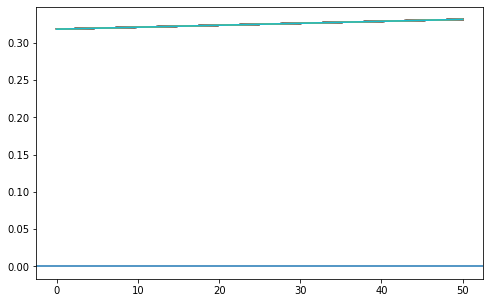

In [161]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

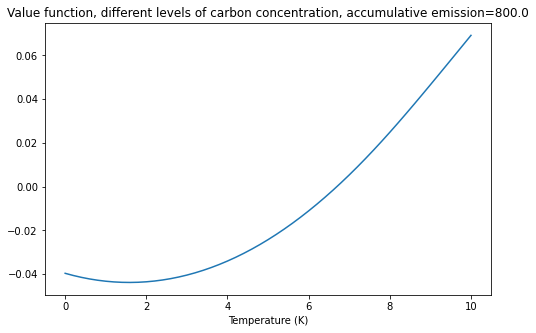

In [162]:
ii = -1
plt.plot(T_grid, v0[:, -1, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

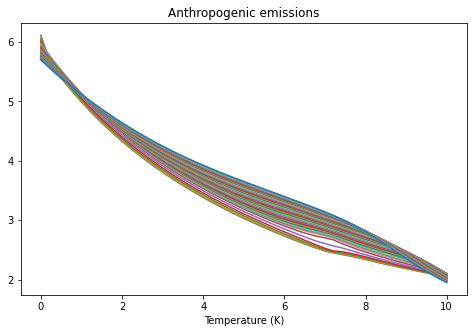

In [163]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

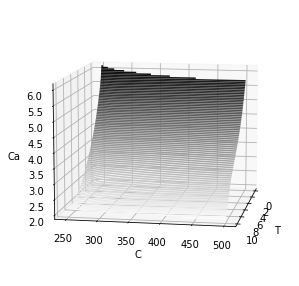

In [164]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [170]:
t_max = 100.
dt = 1/12
dt = 1  # , Gigaton per year
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + 1.1
C_0 = 275.5
F_0 = (870 - 580) / 2.13 # total cumulated, as of now, preindustrial with Fo


def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To)
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 1.0, '$S_a$')

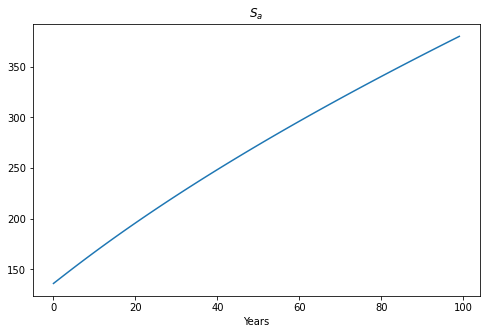

In [171]:
plt.plot(years[:-1], hist[:-1, 2])
plt.xlabel("Years")
plt.title("$S_a$")

Text(0.5, 1.0, 'Emission in ppm')

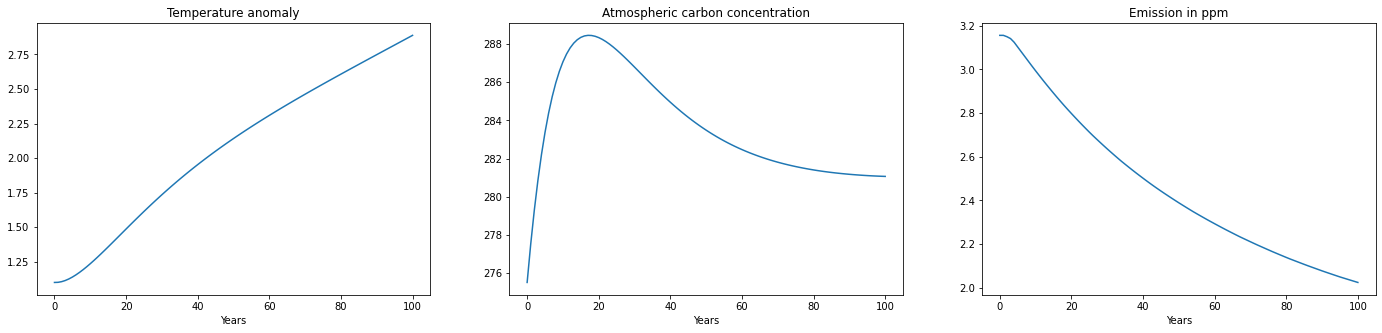

In [178]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission in ppm")

In [ ]:
hist[]hist[0, 0]

In [173]:
res = {
    "v0": v0,
    "T": T_grid,
    "C": C_grid,
    "F": F_grid,
}

pickle.dump(res, open(f"./data_{cearth}", "wb"))

In [174]:
Et = e_hist * 2.13

Text(0.5, 1.0, 'Emission in GtC')

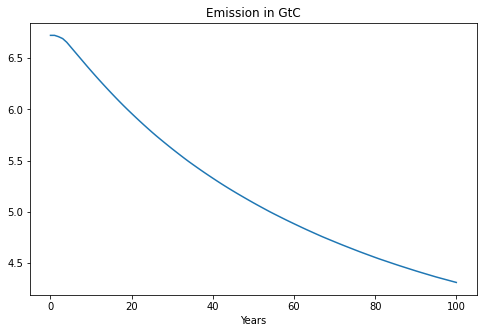

In [179]:
plt.plot(years, Et)
plt.xlabel("Years")
plt.title("Emission in GtC")

In [181]:
df = pd.DataFrame({
    'Years': years,
    'Et(Gigaton)': Et,
                  })

df.to_csv("Et.csv", index=False)